# La Palma Earthquakes

> The first heading in the document is the Article Title.

> The notebook should include an abstract cell at the beginning. If you inspect the metadata for this cell, you will find `"part": "abstract"`. This metadata is required for recognizing the content of this cell as the abstract.
>
>The abstract should begin with a short description of the problem addressed, briefly describe the new data or analyses, then briefly state the main conclusion(s) and how they are supported, and address any uncertainty.

In September 2021, a significant jump in seismic activity on the island of La Palma (Canary Islands, Spain) signaled the start of a volcanic crisis that still continues at the time of writing. Earthquake data is continually collected and published by the Instituto Geográphico Nacional (IGN). We have created an accessible dataset from this and completed preliminary data analysis which shows seismicity originating at two distinct depths, consistent with the model of a two reservoir system feeding the currently very active volcano.

# Introduction

> The content of your notebook may be broken into any number of markdown or code cells. Markdown cells use MyST markdown and support [standard markdown typography](https://myst-tools.org/docs/mystjs/typography) and many [directives and roles](https://myst-tools.org/docs/mystjs/syntax-overview) for figures, tables, equations, etc.

La Palma is one of the west most islands in the Volcanic Archipelago of the Canary Islands, a Spanish territory situated is the Atlantic Ocean where at their closest point are 100km from the African coast [Figure %s](#map) The island is one of the youngest, remains active and is still in the island forming stage.

> Figures may be added to your notebook using the [figure directive](https://myst-tools.org/docs/mystjs/figures). They may refer to images saved in your `images/` folder, images from the web, or notebook cell outputs [referenced by label](https://myst-tools.org/docs/mystjs/cross-references#targeting-cells). The `:name:` is used to reference the figure in your text; a reference to the following figure is found in the paragraph above. The figure caption is given as the body of this directive.

```{figure} images/la-palma-map.png
:name: map
:align: center
:width: 100%

Map of La Palma in the Canary Islands. Image credit [NordNordWest](https://commons.wikimedia.org/w/index.php?curid=76638603)
```

La Palma has been constructed by various phases of volcanism, the most recent and currently active being the *Cumbre Vieja* volcano, a north-south volcanic ridge that constitutes the southern half of the island.

## Eruption History

A number of eruptions were recorded since the colonization of the islands by Europeans in the late 1400s, these are summarised in [Table %s](#history).

> Simple tables may be created using the [list-table directive](https://myst-tools.org/docs/mystjs/tables). Similar to figures, tables may be referenced in the text by their `name`. The caption for this table is the first line of the directive.

~~~{list-table} Recent historic eruptions on La Palma
:header-rows: 1
:name: history
* - Name
  - Year
* - Current
  - 2021
* - Teneguía
  - 1971
* - Nambroque
  - 1949
* - El Charco
  - 1712
* - Volcán San Antonio
  - 1677
* - Volcán San Martin
  - 1646
* - Tajuya near El Paso
  - 1585
* - Montaña Quemada
  - 1492
~~~

This equates to an eruption on average every 79 years up until the 1971 event. The probability of a future eruption can be modeled by a Poisson distribution [](#poisson).

> Numbered equations may be defined using the [math directive or in line](https://myst-tools.org/docs/mystjs/math). Equations defined with the math directive may be reference in the text by label.

```{math}
:label: poisson

p(x)=\frac{e^{-\lambda} \lambda^{x}}{x !}
```

Where $\lambda$ is the number of eruptions per year, $\lambda=\frac{1}{79}$ in this case. The probability of a future eruption in the next $t$ years can be calculated by:

```{math}
:label: probability

p_e = 1-\mathrm{e}^{-t \lambda}
```

So following the 1971 eruption the probability of an eruption in the following 50 years — the period ending this year — was 0.469. After the event, the number of eruptions per year moves to $\lambda=\frac{1}{75}$ and the probability of a further eruption within the next 50 years (2022-2071) rises to 0.487 and in the next 100 years, this rises again to 0.736.

## Magma Reservoirs

> You may [add citations two ways](https://myst-tools.org/docs/mystjs/citations). First, you may simply insert a markdown link link to a DOI like so: [](10.1093/nar/22.22.4673). No additional bibliographic information is required for this approach; the reference will be looked up by DOI and added implicitly to the references. Alternatively, you may provide the bibliography directly as `references.bib` BibTeX file, then embed the citation by BibTeX key in your text using the `cite:p` or `cite:t` for parenthetical or textual citations, respectively. The following paragraph provides an example of this. A single paper may combine both DOI and BibTeX citations.

Studies of the magma systems feeding the volcano, such as {cite:p}`marrero2019` has proposed that there are two main magma reservoirs feeding the Cumbre Vieja volcano; one in the mantle (30-40km depth) which charges and in turn feeds a shallower crustal reservoir (10-20km depth).

```{figure} images/reservoirs.png
:name: reservoirs
:align: center
:width: 100%

Proposed model from {cite:t}`marrero2019`
```

In this paper, we look at recent seismicity data to see if we can see evidence of such a system action, see [Figure %s](#reservoirs).


# Dataset

> All data used in the notebook should be present in the `data/` folder so notebooks may be executed in place with no additional input.

The earthquake dataset used in our analysis was generated from the [IGN web portal](https://www.ign.es/web/resources/volcanologia/tproximos/canarias.html) this is public data released under a permissive license. Data recorded using the network of Seismic Monitoring Stations on the island. A web scraping script was developed to pull data into a machine-readable form for analysis. That code tool [is available on GitHub](https://github.com/stevejpurves/ign-earthquake-data) along with a copy of recently updated data.

## Main Timeline Figure

> Code cells may be seamlessly interleaved with markdown cells. Currently, with a single-article submission, code cannot be hidden in the output document.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

In [2]:
def make_category_columns(df):
    df['Depth'] = 'Shallow (<18km)'
    df.loc[(df['Depth(km)'] >= 18) & (df['Depth(km)'] <= 28), 'Depth'] = 'Interchange (18km>x>28km)'
    df.loc[df['Depth(km)'] >= 28, 'Depth'] = 'Deep (>28km)'
    
    df['Mag'] = 0
    df.loc[(df['Magnitude'] >= 1) & (df['Magnitude'] <= 2), 'Mag'] = 1
    df.loc[(df['Magnitude'] >= 2) & (df['Magnitude'] <= 3), 'Mag'] = 2
    df.loc[(df['Magnitude'] >= 3) & (df['Magnitude'] <= 4), 'Mag'] = 3
    df.loc[(df['Magnitude'] >= 4) & (df['Magnitude'] <= 5), 'Mag'] = 4    
    
    return df

## Visualising Long term earthquake data

Data taken directly from the IGN Catalog

> Supported cell outputs below include `pandas` dataframe, raw text output, `matplotlib` plot, and `seaborn` plot.

In [7]:
df_ign = pd.read_csv('./data/lapalma_ign.csv')
df_ign = make_category_columns(df_ign)
df_ign.head()

,Event,Date,UTC time,Local time(*),Latitude,Longitude,Depth(km),Magnitude,Mag. type,Max. int,Region,More Info,Depth,Mag
0,es2022cibon,2022-02-02,20:46:39,21:46:39,40.7805,3.4874,2.0,2.0,mbLg,NaN,MEDITERRÁNEO-BALEARES,NaN,Shallow (<18km),2
1,es2022cibcw,2022-02-02,20:33:08,21:33:08,35.4494,-3.6606,13.0,2.3,mbLg,NaN,ALBORÁN SUR,NaN,Shallow (<18km),2
2,es2022ciaxl,2022-02-02,20:26:45,21:26:45,35.4879,-3.6302,27.0,2.0,mbLg,NaN,ALBORÁN SUR,NaN,Interchange (18km>x>28km),2
3,es2022ciavv,2022-02-02,20:24:52,21:24:52,35.4216,-3.6531,17.0,2.3,mbLg,NaN,ALBORÁN SUR,NaN,Shallow (<18km),2
4,es2022chvdg,2022-02-02,17:31:41,17:31:41,28.6224,-17.9208,0.0,1.7,mbLg,NaN,SE TAZACORTE.ILP,NaN,Shallow (<18km),1


In [16]:
df_ign['DateTime'] = pd.to_datetime(df_ign['Date'] + ' ' + df_ign['Local time(*)'])
df_ign['DateTime']

0       2022-02-02 21:46:39
1       2022-02-02 21:33:08
2       2022-02-02 21:26:45
3       2022-02-02 21:24:52
4       2022-02-02 17:31:41
                ...        
12465   2021-08-31 02:30:13
12466   2021-08-31 02:28:39
12467   2021-08-31 02:27:43
12468   2021-08-31 02:25:20
12469   2021-08-31 02:02:21
Name: DateTime, Length: 12470, dtype: datetime64[ns]

In [17]:
df_ign_early = df_ign[df_ign['DateTime'] < '2021-09-11']
df_ign_pre = df_ign[(df_ign['DateTime'] >= '2021-09-11')&(df_ign['DateTime'] < '2021-09-19 14:13:00')]
df_ign_phase1 = df_ign[(df_ign['DateTime'] >= '2021-09-19 14:13:00')&(df_ign['DateTime'] < '2021-10-01')]
df_ign_phase2 = df_ign[(df_ign['DateTime'] >= '2021-10-01')&(df_ign['DateTime'] < '2021-12-01')]
df_ign_phase3 = df_ign[(df_ign['DateTime'] >= '2021-12-01')&(df_ign['DateTime'] <= '2021-12-31')]

df_erupt = df_ign[(df_ign['Date'] < '2022-01-01') & (df_ign['Date'] > '2021-09-11')]

df_erupt_1 = df_erupt[df_erupt['Magnitude'] < 1.0]
df_erupt_2 = df_erupt[(df_erupt['Magnitude'] >= 1.0)&(df_erupt['Magnitude'] < 2.0)]
df_erupt_3 = df_erupt[(df_erupt['Magnitude'] >= 2.0)&(df_erupt['Magnitude'] < 3.0)]
df_erupt_4 = df_erupt[(df_erupt['Magnitude'] >= 3.0)&(df_erupt['Magnitude'] < 4.0)]
df_erupt_5 = df_erupt[df_erupt['Magnitude'] > 4.0]


In [18]:
tab10_colors = (
    (0.12156862745098039, 0.4666666666666667,  0.7058823529411765  ),  # 1f77b4
    (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
    (0.17254901960784313, 0.6274509803921569,  0.17254901960784313 ),  # 2ca02c
    (0.8392156862745098,  0.15294117647058825, 0.1568627450980392  ),  # d62728
    (0.5803921568627451,  0.403921568627451,   0.7411764705882353  ),  # 9467bd
    (0.5490196078431373,  0.33725490196078434, 0.29411764705882354 ),  # 8c564b
    (0.8901960784313725,  0.4666666666666667,  0.7607843137254902  ),  # e377c2
    (0.4980392156862745,  0.4980392156862745,  0.4980392156862745  ),  # 7f7f7f
    (0.7372549019607844,  0.7411764705882353,  0.13333333333333333 ),  # bcbd22
    (0.09019607843137255, 0.7450980392156863,  0.8117647058823529),    # 17becf
)

tab20_colors = (
    (0.12156862745098039, 0.4666666666666667,  0.7058823529411765  ),  # 1f77b4
    (0.6823529411764706,  0.7803921568627451,  0.9098039215686274  ),  # aec7e8
    (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
    (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
    (0.17254901960784313, 0.6274509803921569,  0.17254901960784313 ),  # 2ca02c
    (0.596078431372549,   0.8745098039215686,  0.5411764705882353  ),  # 98df8a
    (0.8392156862745098,  0.15294117647058825, 0.1568627450980392  ),  # d62728
    (1.0,                 0.596078431372549,   0.5882352941176471  ),  # ff9896
    (0.5803921568627451,  0.403921568627451,   0.7411764705882353  ),  # 9467bd
    (0.7725490196078432,  0.6901960784313725,  0.8352941176470589  ),  # c5b0d5
    (0.5490196078431373,  0.33725490196078434, 0.29411764705882354 ),  # 8c564b
    (0.7686274509803922,  0.611764705882353,   0.5803921568627451  ),  # c49c94
    (0.8901960784313725,  0.4666666666666667,  0.7607843137254902  ),  # e377c2
    (0.9686274509803922,  0.7137254901960784,  0.8235294117647058  ),  # f7b6d2
    (0.4980392156862745,  0.4980392156862745,  0.4980392156862745  ),  # 7f7f7f
    (0.7803921568627451,  0.7803921568627451,  0.7803921568627451  ),  # c7c7c7
    (0.7372549019607844,  0.7411764705882353,  0.13333333333333333 ),  # bcbd22
    (0.8588235294117647,  0.8588235294117647,  0.5529411764705883  ),  # dbdb8d
    (0.09019607843137255, 0.7450980392156863,  0.8117647058823529  ),  # 17becf
    (0.6196078431372549,  0.8549019607843137,  0.8980392156862745),    # 9edae5
)

tab20c_colors = (
    (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd
    (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
    (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
    (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
    (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d
    (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
    (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
    (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
    (0.19215686274509805, 0.6392156862745098,  0.32941176470588235 ),  # 31a354
    (0.4549019607843137,  0.7686274509803922,  0.4627450980392157  ),  # 74c476
    (0.6313725490196078,  0.8509803921568627,  0.6078431372549019  ),  # a1d99b
    (0.7803921568627451,  0.9137254901960784,  0.7529411764705882  ),  # c7e9c0
    (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
    (0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
    (0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
    (0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
    (0.38823529411764707, 0.38823529411764707, 0.38823529411764707 ),  # 636363
    (0.5882352941176471,  0.5882352941176471,  0.5882352941176471  ),  # 969696
    (0.7411764705882353,  0.7411764705882353,  0.7411764705882353  ),  # bdbdbd
    (0.8509803921568627,  0.8509803921568627,  0.8509803921568627  ),  # d9d9d9
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


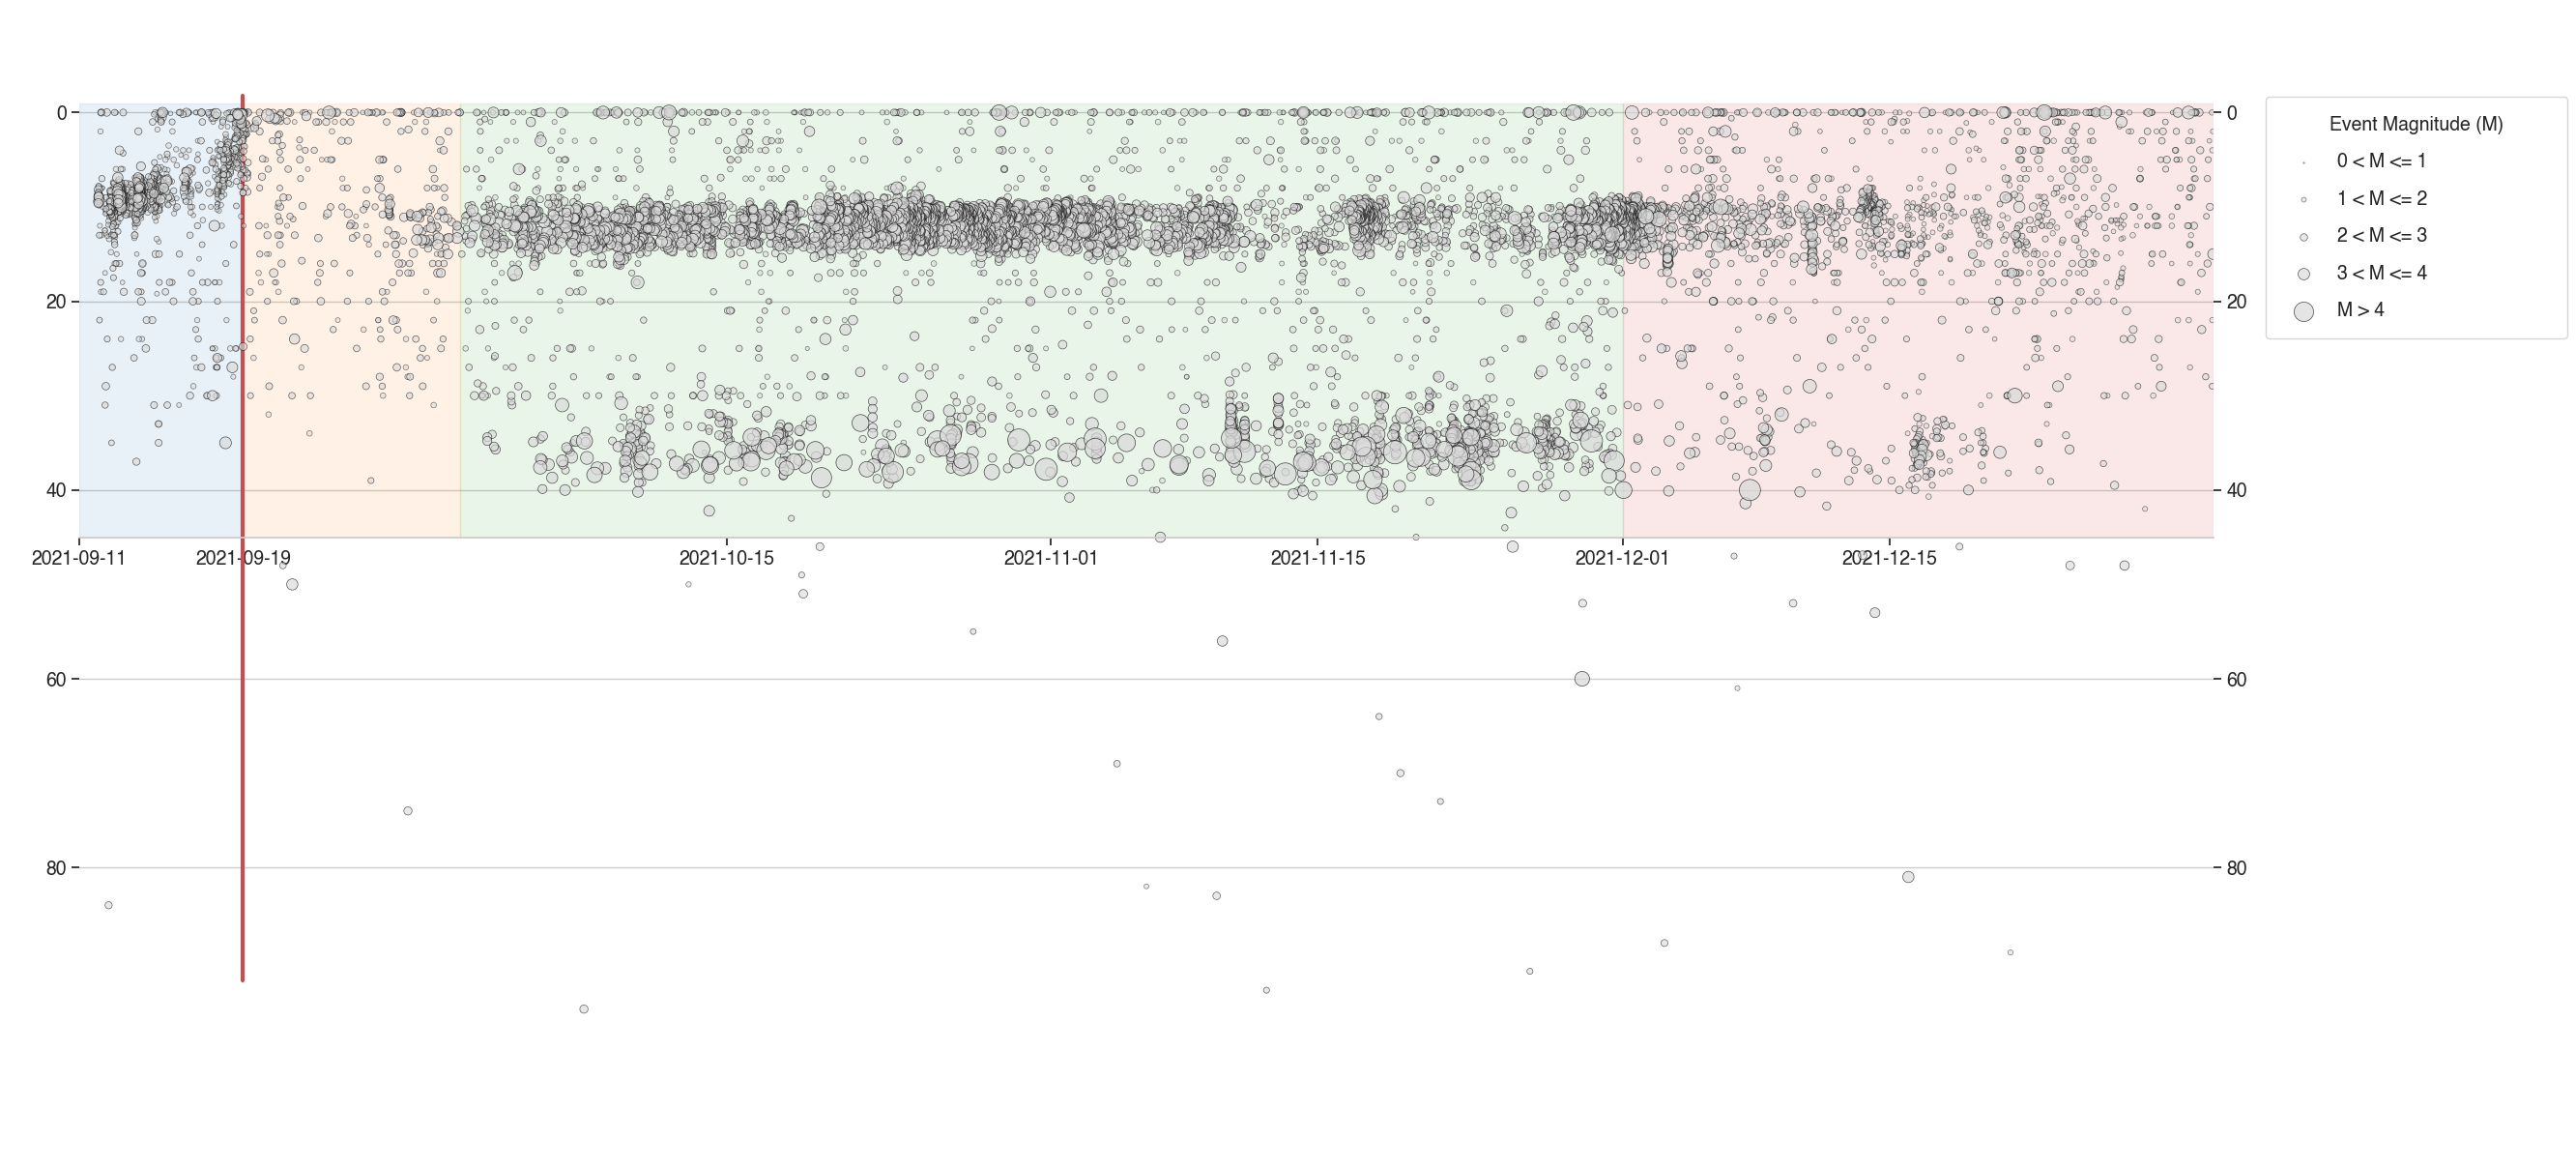

In [19]:
from matplotlib.patches import Rectangle

import datetime as dt
from matplotlib.dates import date2num, num2date

matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.labelright'] = True

%matplotlib inline
fig = matplotlib.pyplot.figure(figsize=(24,12))
fig.tight_layout()
# Creating axis
# add_axes([xmin,ymin,dx,dy])
ax_min = fig.add_axes([0.01, 0.01, 0.01, 0.01])
ax_min.axis('off')
ax_max = fig.add_axes([0.99, 0.99, 0.01, 0.01])
ax_max.axis('off')

ax_timeline = fig.add_axes([0.04, 0.1, 0.92, 0.85])
ax_timeline.spines["top"].set_visible(False)
ax_timeline.spines["right"].set_visible(False)
ax_timeline.spines["left"].set_visible(False)
ax_timeline.grid(axis='x')


ax_timeline.axvline(x=dt.datetime(2021, 9, 19, 14, 13), ymin=0.075, ymax=0.972, color='r', linewidth=3)


def make_scatter(df, c, alpha=0.8):
    M = 3*np.exp2(1.3*df['Magnitude'])
    return ax_timeline.scatter(df['DateTime'], df['Depth(km)'], s=M, c=c, alpha=alpha, edgecolor='black', linewidth=0.5, zorder=2);

# make_scatter(df_erupt, c=tab20c_colors[-1])
points_1 = make_scatter(df_erupt_1, c=[tab20c_colors[-1]], alpha=0.5)
points_2 = make_scatter(df_erupt_2, c=[tab20c_colors[-1]], alpha=0.5)
points_3 = make_scatter(df_erupt_3, c=[tab20c_colors[-1]], alpha=0.6)
points_4 = make_scatter(df_erupt_4, c=[tab20c_colors[-1]], alpha=0.65)
points_5 = make_scatter(df_erupt_5, c=[tab20c_colors[-1]], alpha=0.7)

ax_timeline.tick_params(axis='x', labelrotation=0, bottom=True)
ax_timeline.set_ylabel('')
ax_timeline.yaxis.set_ticks_position('both')
ax_timeline.yaxis.set_ticks_position('both')


xticks = ax_timeline.get_xticks()
new_xticks = [date2num(pd.to_datetime('2021-09-11')),
    date2num(pd.to_datetime('2021-09-19 14:13:00'))]
new_xticks = np.append(new_xticks, xticks[2:-1])
ax_timeline.set_xticks(new_xticks)


ax_timeline.invert_yaxis()
ax_timeline.spines['bottom'].set_position(('data', 45))
ax_timeline.margins(tight=True, x=0)
ax_timeline.legend(
    [points_1, points_2, points_3, points_4, points_5],
    ['0 < M <= 1','1 < M <= 2','2 < M <= 3','3 < M <= 4','M > 4'],
    loc='best', bbox_to_anchor=(1.02, 0.88, 0.15, 0.1), fancybox=True, borderpad=1.0, labelspacing=1, mode="expand", title="Event Magnitude (M)", fontsize=14, title_fontsize=14)


ax_timeline.add_patch(Rectangle((date2num(pd.to_datetime('2021-09-11')), -1), date2num(pd.to_datetime('2021-09-19 14:13:00'))-date2num(pd.to_datetime('2021-09-11')), 46, color=tab20_colors[0], zorder=1, alpha=0.1))
ax_timeline.add_patch(Rectangle((date2num(pd.to_datetime('2021-09-19 14:13:00')), -1), date2num(pd.to_datetime('2021-10-01'))-date2num(pd.to_datetime('2021-09-19 14:13:00')), 46, color=tab20_colors[2], zorder=1, alpha=0.1))
ax_timeline.add_patch(Rectangle((date2num(pd.to_datetime('2021-10-01')), -1), date2num(pd.to_datetime('2021-12-01'))-date2num(pd.to_datetime('2021-10-01')), 46, color=tab20_colors[4], zorder=1, alpha=0.1))
ax_timeline.add_patch(Rectangle((date2num(pd.to_datetime('2021-12-01')), -1), date2num(pd.to_datetime('2021-12-31'))-date2num(pd.to_datetime('2021-12-01'))+1, 46, color=tab20_colors[6], zorder=1, alpha=0.1));


plt.savefig('timeline_grey_with_panels.eps', format='eps')


## Cumulative Distrubtion Plots

In [20]:
def cumulative_events_mag_depth(df, hue='Depth', kind='scatter', ax=None, dpi=300, palette=None, kde=True):
    matplotlib.rcParams['ytick.labelright'] = False
    g = sns.jointplot(x="Magnitude", y="Depth(km)", data=df,
                      kind=kind, hue=hue, height=10, space=0.1, marginal_ticks=False, ratio=8, alpha=0.6,
                      hue_order=['Shallow (<18km)', 'Interchange (18km>x>28km)', 'Deep (>28km)'],
                      ax=ax, palette=palette, ylim=(-2,50), xlim=(0.3,5.6), edgecolor=".2", marginal_kws=dict(bins=20, hist_kws={'edgecolor': 'black'}))
    if kde:
        g.plot_joint(sns.kdeplot, color="b", zorder=1, levels=15, ax=ax)
    g.fig.axes[0].invert_yaxis();
    g.fig.set_dpi(dpi)

    
def cumulative_events_spatial(df, hue='Depth', kind='scatter', ax=None, dpi=300, palette=None):
    g = sns.jointplot(x="Longitude", y="Depth(km)", data=df,
                      kind=kind, hue=hue, color="m", height=10, palette=palette,
                      hue_order=['Shallow (<18km)', 'Interchange (18km>x>28km)',  'Deep (>28km)', ], ax=ax, ylim=(-2,50))
    g.plot_joint(sns.kdeplot, color="b", zorder=1, levels=15, ax=ax)
    g.fig.axes[0].invert_yaxis();

/Users/franklin/opt/miniconda3/envs/jb/lib/python3.10/site-packages/seaborn/axisgrid.py:2214: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): hist_kws.
  warnings.warn(msg, UserWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


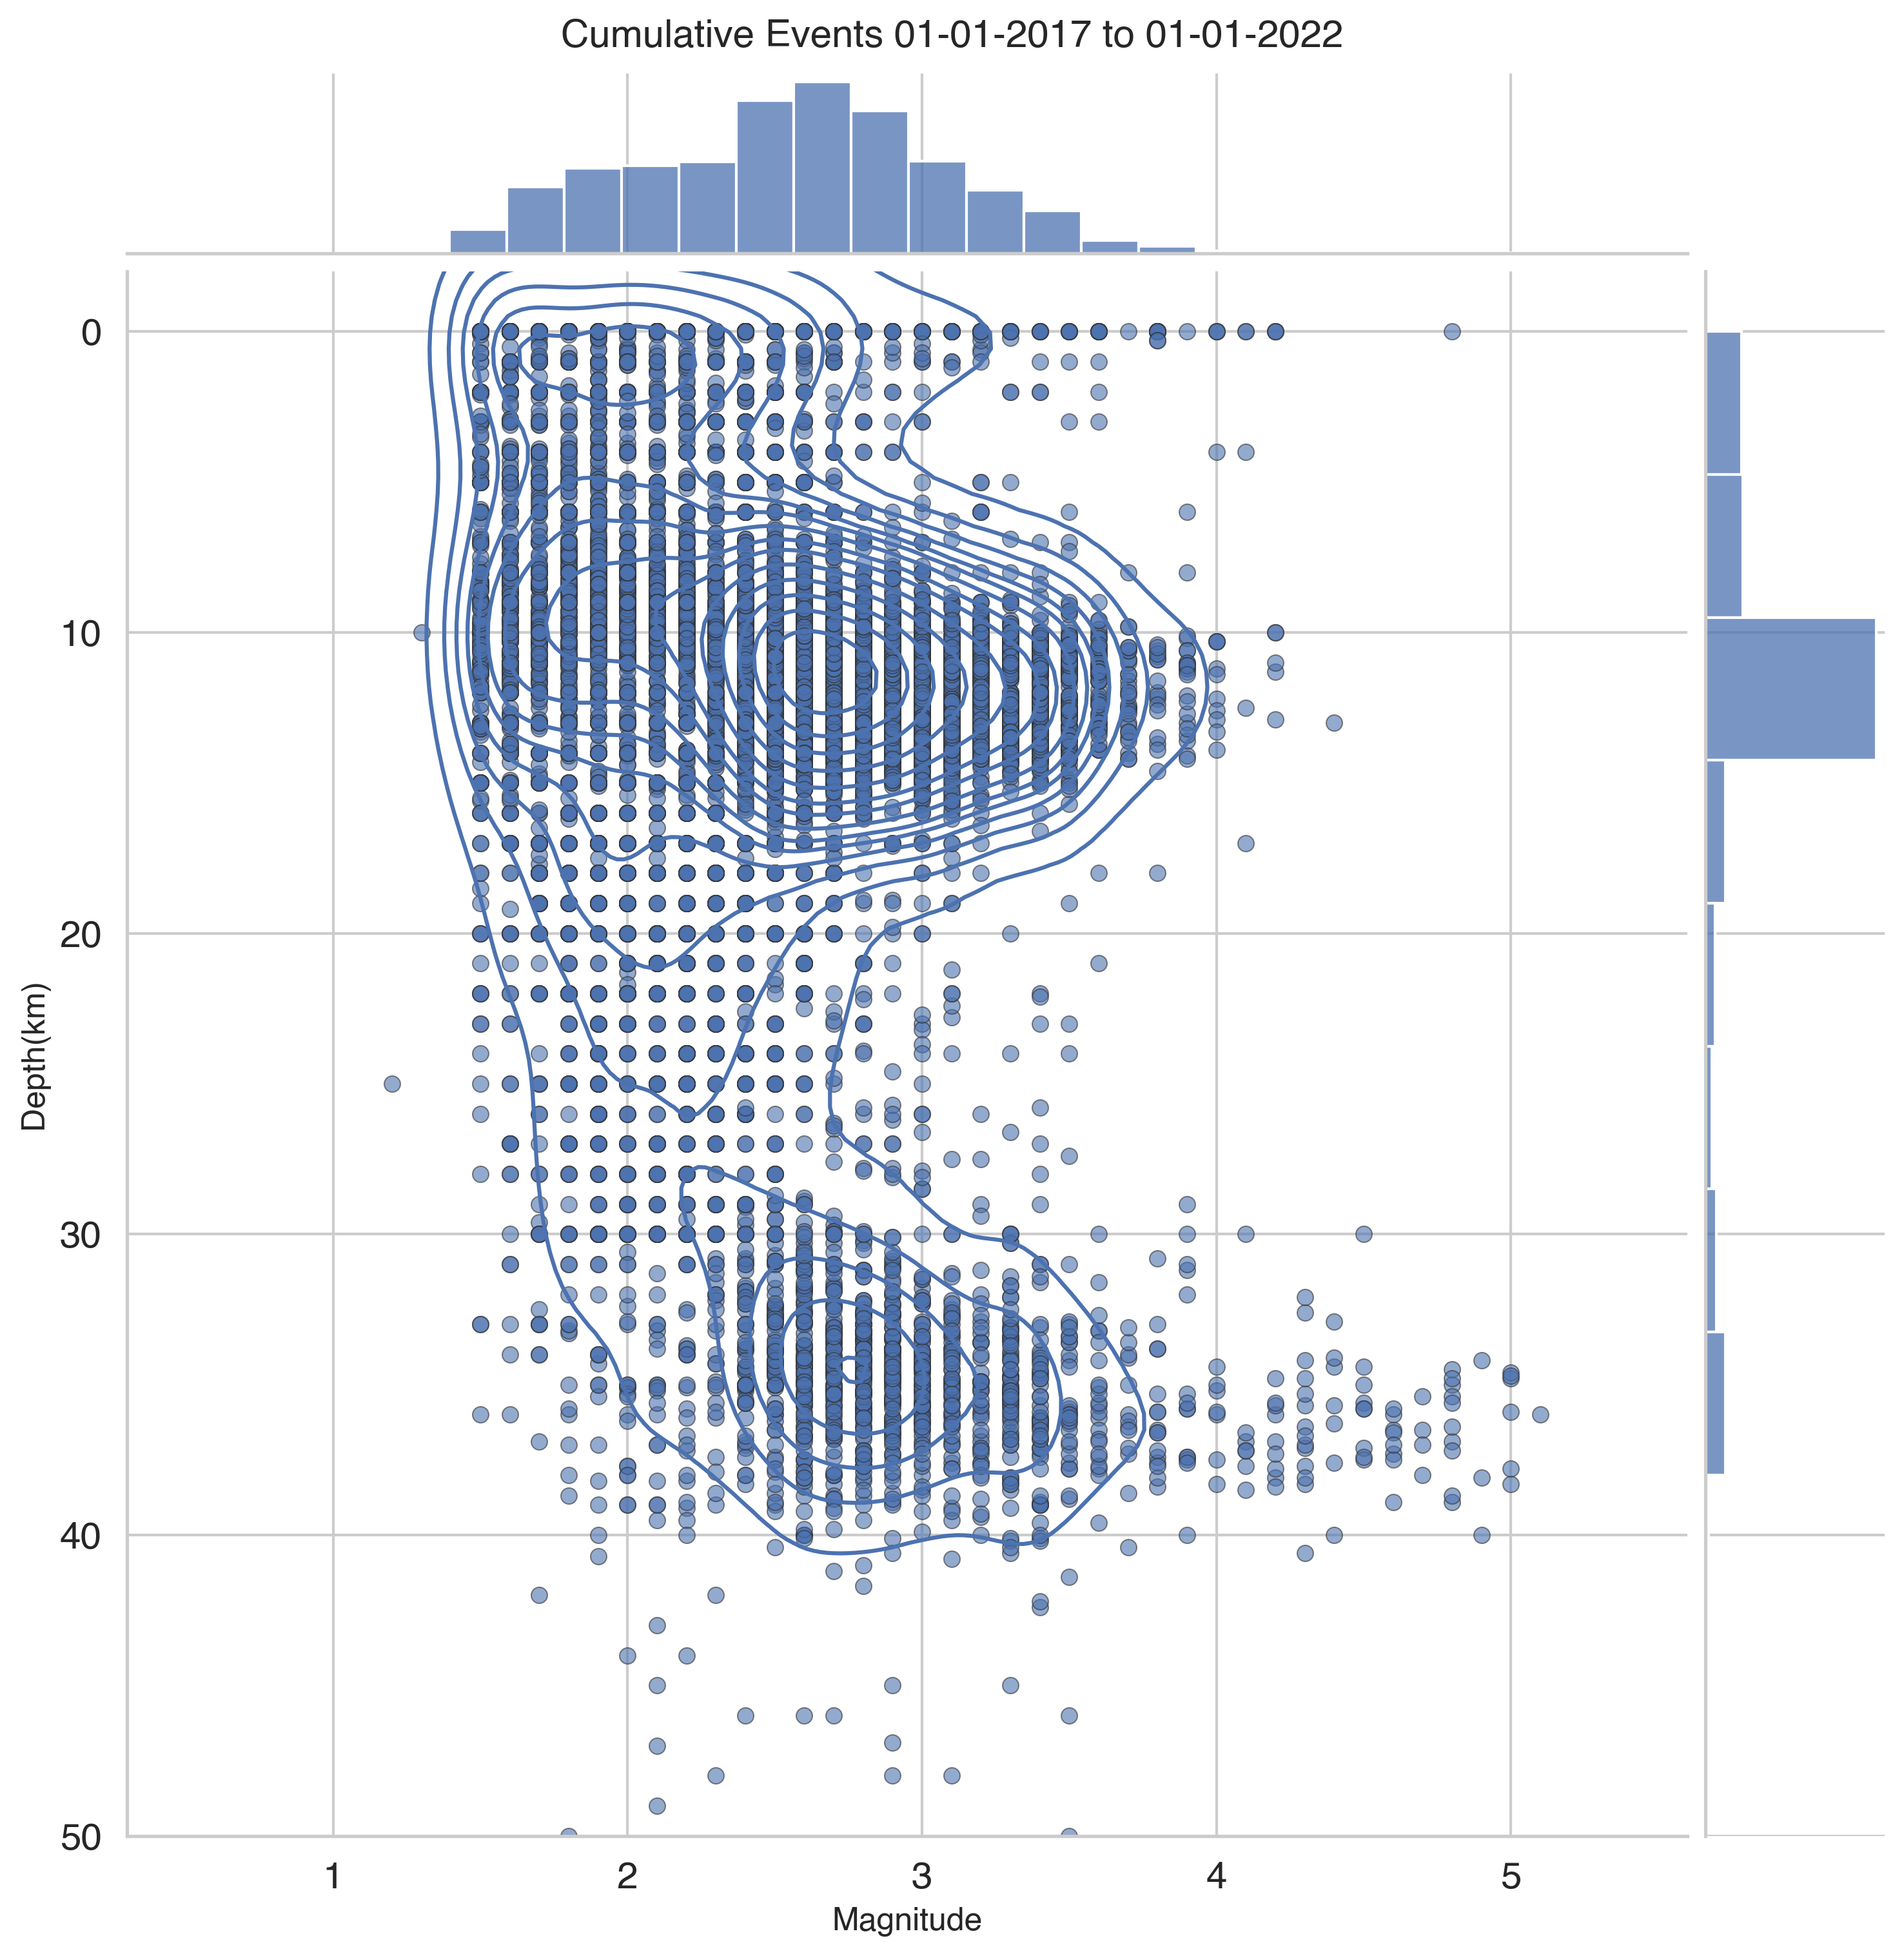

In [21]:
cumulative_events_mag_depth(df_ign, hue=None)
plt.suptitle('Cumulative Events 01-01-2017 to 01-01-2022', y=1.01);
plt.savefig('cuml_events_all.eps', format='eps')

# Results

The dataset was loaded into this Jupyter notebook and filtered down to La Palma events only. This results in 5465 data points which we then visualized to understand their distributions spatially, by depth, by magnitude and in time.

From our analysis above, we can see 3 different systems in play.

Firstly, the shallow earthquake swarm leading up to the eruption on 19th September, related to significant surface deformation and shallow magma intrusion.

After the eruption, continuous shallow seismicity started at 10-15km corresponding to magma movement in the crustal reservoir.

Subsequently, high magnitude events begin occurring at 30-40km depths corresponding to changes in the mantle reservoir. These are also continuous but occur with a lower frequency than in the crustal reservoir.

# Conclusions

From the analysis of the earthquake data collected and published by IGN for the period of 11 September through to 9 November 2021. Visualization of the earthquake events at different depths appears to confirm the presence of both mantle and crustal reservoirs as proposed by {cite:t}`marrero2019`.

> Data availability statement should be specified in a separate cell with metadata `"part": "availability"`, similar to the abstract.

A web scraping script was developed to pull data into a machine-readable form for analysis. That code tool [is available on GitHub](https://github.com/stevejpurves/ign-earthquake-data) along with a copy of recently updated data.